<h1>Federated Learning: Version Age of Information Scheduling</h1>

<t>This notebook implements Version Age-based Scheduling using the MNIST and CIFAR-10 Datasets.

> Two models are considered,
> 1. A Multi-layer Perceptron comprising of two hidden layers with 64 units each, utilizing the ReLU activation function
> 2. A Convolutional Neural Network encompassing two convolutional layers with max pooling, two fully connected layers, and a softmax output layer

> Two types of data distributions were considered when using the MNIST Dataset,
>1. IID: Data is shuffled and then divided up across 100 clients each receiving 600 examples
>2. Non-IID: Data is sorted by digit label, divided up into 200 'shards' of 300 examples, and then each client receieves 2 'shards

</t>


In [271]:
# Import Global Dependencies
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch
import torch.nn.functional as F

# Import Helper Libaries
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import random
import time

filepath = "C:/Users/aidan_000/Desktop/UNCC/Github/Fed-Learning/data" 

<h2>Multi-layer Perceptron Model Architecture</h2>

<t>*"The initial experiment involves training an MLP with the MNIST dataset. This MLP comprises two
hidden layers with 64 units each, utilizing the ReLU activation function"*</t>

In [272]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # MNIST images are 28x28
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

<h2>CIFAR-10 CNN Model Architecture</h2>

<t>*The second experiment focuses on training a Convolutional Neural Network CNN on the CIFAR-10 dataset. The CNN
architecture encompasses two convolutional layers with max pooling, two fully connected layers, and a softmax output
layer*</t>

In [273]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64*8*8, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

<h2>Federated Learning Algorithms</h2>

<h3>Global Aggregator</h3>

In [274]:
def global_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

<h3>Global Model Evaluation</h3>

In [275]:
def model_evaluation(global_model, validation_loader):
    global_model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = global_model(inputs)
            loss += nn.CrossEntropyLoss()(output, labels).item()  # Using the criterion
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == labels).sum().item()

    loss /= len(validation_loader.dataset)
    accuracy = correct / len(validation_loader.dataset)

    return loss, accuracy

<h3>Client Update</h3>

In [276]:
def client_update(client, optimizer, training_loader, epochs):
    client.train()
    for epoch in range(epochs):
        for batch_idx, (inputs, labels) in enumerate(training_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = client(inputs)
            loss = F.cross_entropy(output, labels)
            loss.backward()
            optimizer.step()
    return loss.item()

<h3>Training using Age Age-based (AoU)</h3>


In [277]:
def ABS_training(model_type, global_model, lr, total_clients, clients_per_round, total_rounds, local_epochs, training_loaders, validation_loader):
    clients = [model_type().to(device) for _ in range(total_clients)]
    
    for models in clients:
        models.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(models.parameters(), lr=lr) for models in clients]
    clients_age = np.zeros(total_clients)
    
    average_losses, valid_losses, valid_accuracies = [], [], []

    global_start_time = time.time()
    for round in range(total_rounds):
        start_time = time.time()

        # Age-based scheduling: select the clients with the highest age
        old_clients_idx = np.argsort(clients_age)[-clients_per_round:]

        clients_age += 1
        clients_age[old_clients_idx] = 0  # Reset the age of the selected clients

        client_losses = 0      
        selected_models = []
        
        for i in range(clients_per_round):
            clients[old_clients_idx[i]].load_state_dict(global_model.state_dict())
            client_losses += client_update(clients[old_clients_idx[i]], opt[old_clients_idx[i]], training_loaders[old_clients_idx[i]], local_epochs)
            selected_models.append(clients[old_clients_idx[i]])
        

        global_aggregate(global_model, selected_models)
    
        avg_loss = client_losses / clients_per_round
        valid_loss , valid_accuracy = model_evaluation(global_model, validation_loader)

        average_losses.append(avg_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
    
        end_time = time.time()
        round_time = end_time - start_time
    
        if (round % 10) == 0:
            rounds_end_time = time.time()
            rounds_time = rounds_end_time - global_start_time
            print('Round {:3d}, Time (secs) {:.2f}: Average loss {:.4f}, Validation Loss {:.4f}, Validation Accuracy {:.4f}'.format(round + 1, rounds_time, avg_loss, valid_loss, valid_accuracy))
    return average_losses, valid_losses, valid_accuracies

<h3>Training using Version Age-based (VAoI)</h3>

In [278]:
def VAoI_client_map(client_models, training_loaders):
    client_map = {}
    for idx, client_model in enumerate(client_models):
        client_id = f"client_{idx + 1}"
        optimizer = optim.SGD(client_model.parameters(), lr=lr)
        client_map[client_id] = {
            'model': client_model,
            'optimizer': optimizer,
            'training_loader': training_loaders[idx],
            'accuracies': [],
            'losses': [],
            'version_age': 0
        }
    return client_map

In [279]:
def manhattan_norm(client_model, global_model):
    client_weights = client_model.state_dict()
    global_weights = global_model.state_dict()
    for key in client_weights.keys():
        norm = torch.norm(client_weights[key] - global_weights[key], p=1)
        norm = norm.item()
    return norm

In [280]:
def VAoI_Scheduler(client_map, global_model, tau, h=lambda x: np.exp(x)):
    num_clients = len(client_map)
    client_version_ages = []

    # Calculate the version age for each client
    for client_id, client_info in client_map.items():
        model = client_info['model']
        distance = manhattan_norm(model, global_model)
        if distance >= tau:
            client_info['version_age'] += 1
        client_version_ages.append(client_info['version_age'])

    # Calculate the selection probabilities based on version age
    selection_probs = [h(age) for age in client_version_ages]
    selection_probs = [prob / sum(selection_probs) for prob in selection_probs]

    # Select the clients based on the probabilities
    selected_clients = np.random.choice(list(client_map.keys()), size=int(0.1 * num_clients), p=selection_probs, replace=False)

    # Reset the version age for the selected clients
    for client_id in selected_clients:
        client_map[client_id]['version_age'] = 0

    return selected_clients

In [281]:
def VAoI_training(model_type, global_model, lr, total_clients, clients_per_round, total_rounds, local_epochs, training_loaders, validation_loader, tau):
    client_models = [model_type().to(device) for _ in range(total_clients)]
    for models in client_models:
        models.load_state_dict(global_model.state_dict())

    client_map = VAoI_client_map(client_models, training_loaders)
    
    opt = [optim.SGD(models.parameters(), lr=lr) for models in client_models]
    
    average_losses, valid_losses, valid_accuracies = [], [], []

    global_start_time = time.time()
    for round in range(total_rounds):
        start_time = time.time()

        # Use the VAoI scheduler to select the clients
        selected_clients = VAoI_Scheduler(client_map, global_model, tau, h=lambda x: np.exp(x))

        client_losses = 0
        selected_models = []
        for client_id in selected_clients:
            client_info = client_map[client_id]
            client_model = client_info['model']
            client_optimizer = client_info['optimizer']
            client_training_loader = client_info['training_loader']

            # Load the global model weights to the selected client
            client_model.load_state_dict(global_model.state_dict())

            # Perform local training on the selected client
            client_loss = client_update(client_model, client_optimizer, client_training_loader, local_epochs)
            client_losses += client_loss
            selected_models.append(client_model)

        # Aggregate the selected client models to update the global model
        global_aggregate(global_model, selected_models)

        avg_loss = client_losses / len(selected_clients)
        valid_loss, valid_accuracy = model_evaluation(global_model, validation_loader)

        average_losses.append(avg_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        end_time = time.time()
        round_time = end_time - start_time

        if (round % 10) == 0:
            rounds_end_time = time.time()
            rounds_time = rounds_end_time - global_start_time
            print('Round {:3d}, Time (secs) {:.2f}: Average loss {:.4f}, Validation Loss {:.4f}, Validation Accuracy {:.4f}'.format(round + 1, rounds_time, avg_loss, valid_loss, valid_accuracy))

    return average_losses, valid_losses, valid_accuracies

<h2>Hyperparameters for Training Experience</h2>

In [282]:
# Device configuration: use CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning configuration
lr = 0.015
total_rounds = 150  # Total number of training rounds

# Client configuration
total_clients = 100  # Total number of clients
clients_per_round = 10  # Number of clients selected per round

# Local training configuration
local_batchsize = 50  # Batch size for local training
local_epochs = 5  # Number of epochs for local training

tau = 0.1

<h2>IID Data Preparation for MNIST and CIFAR-10 Dataset</h2>
<t>*The IID data is shuffled and then divided up across 100 clients each receiving 600 examples.*  

*Exclusively use independent and identically distributed i.i.d. distributions for CIFAR-10 due to the absence of a natural
data user partition*</t>

In [283]:
MNISTtransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST IID Dataset
MNIST_training_dataset = datasets.MNIST(filepath, train=True, download=True, transform=MNISTtransform)
MNIST_training_datasplit = torch.utils.data.random_split(MNIST_training_dataset, [int(MNIST_training_dataset.data.shape[0] / total_clients) for _ in range(total_clients)])
MNIST_iid_training = [torch.utils.data.DataLoader(x, batch_size=local_batchsize, shuffle=True) for x in MNIST_training_datasplit]

MNIST_validation_dataset = datasets.MNIST(filepath, train=False, download = True, transform=MNISTtransform)
MNIST_iid_validation = torch.utils.data.DataLoader(MNIST_validation_dataset, batch_size=local_batchsize, shuffle=True)


# Load CIFAR-10 dataset
CIFARtransform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

dataset = datasets.CIFAR10(filepath, train=True, download=True, transform=CIFARtransform)

CIFAR10_dataset = torch.utils.data.random_split(dataset, [len(dataset) // total_clients for _ in range(total_clients)])
CIFAR10_training = [torch.utils.data.DataLoader(x, batch_size=local_batchsize, shuffle=True) for x in CIFAR10_dataset]

CIFAR10_validation = torch.utils.data.DataLoader(datasets.CIFAR10(filepath, train=False, transform=CIFARtransform), batch_size=local_batchsize, shuffle=True)

Files already downloaded and verified


<h3>MLP Model Training with MNIST IID</h3>

Training is done using *'Random'* Scheduling, *'Age-based'* Scheduling, and *'Age of Update OR Data Shapley'* Scheduling (See RNG_training, ABS_training, AoU_OR_DataShapley)

In [284]:
MNIST_iid_ABS = MLP().to(device)
MNIST_iid_VAoI = MLP().to(device)

print("\n=== Training: Model - MLP, Schedule - Version Age of Information, Data Distribution - MNIST IID ===")
iid_MNIST_VAoI_avg_losses, iid_MNIST_VAoI_eval_losses, iid_MNIST_VAoI_accuracies = VAoI_training(MLP, MNIST_iid_VAoI, lr, total_clients, clients_per_round, total_rounds, local_epochs, MNIST_iid_training, MNIST_iid_validation, tau)

print("\n=== Training: Model - MLP, Schedule - Age-Based, Data Distribution - MNIST IID ===")
iid_MNIST_ABS_avg_losses, iid_MNIST_ABS_eval_losses, iid_MNIST_ABS_accuracies = ABS_training(MLP, MNIST_iid_ABS, lr, total_clients, clients_per_round, total_rounds, local_epochs, MNIST_iid_training, MNIST_iid_validation)

# Save Final Model
torch.save(MNIST_iid_VAoI.state_dict(), '.\\Models\\MNIST_iid_VAoI.pth')


=== Training: Model - MLP, Schedule - Version Age of Information, Data Distribution - MNIST IID ===
Round   1, Time (secs) 7.41: Average loss 2.0180, Validation Loss 0.0405, Validation Accuracy 0.4952
Round  11, Time (secs) 80.06: Average loss 0.2602, Validation Loss 0.0067, Validation Accuracy 0.9049
Round  21, Time (secs) 153.43: Average loss 0.2361, Validation Loss 0.0053, Validation Accuracy 0.9234
Round  31, Time (secs) 226.42: Average loss 0.1642, Validation Loss 0.0046, Validation Accuracy 0.9322
Round  41, Time (secs) 298.62: Average loss 0.1346, Validation Loss 0.0041, Validation Accuracy 0.9388
Round  51, Time (secs) 370.51: Average loss 0.1388, Validation Loss 0.0037, Validation Accuracy 0.9461
Round  61, Time (secs) 441.71: Average loss 0.0777, Validation Loss 0.0034, Validation Accuracy 0.9493
Round  71, Time (secs) 512.69: Average loss 0.0717, Validation Loss 0.0031, Validation Accuracy 0.9519
Round  81, Time (secs) 585.01: Average loss 0.0490, Validation Loss 0.0029, Va

<h4>MLP Model Training/Inferencing Experience Comparison for MNIST IID</h4>

=================================== Final MLP Model Accuracies per Schedule ====================================
Version Age of Information Scheduled MNIST IID Model Accuracy: 0.021696437429636718,
Age-based Scheduled MNIST IID Model Accuracy: 0.0021138309956062586


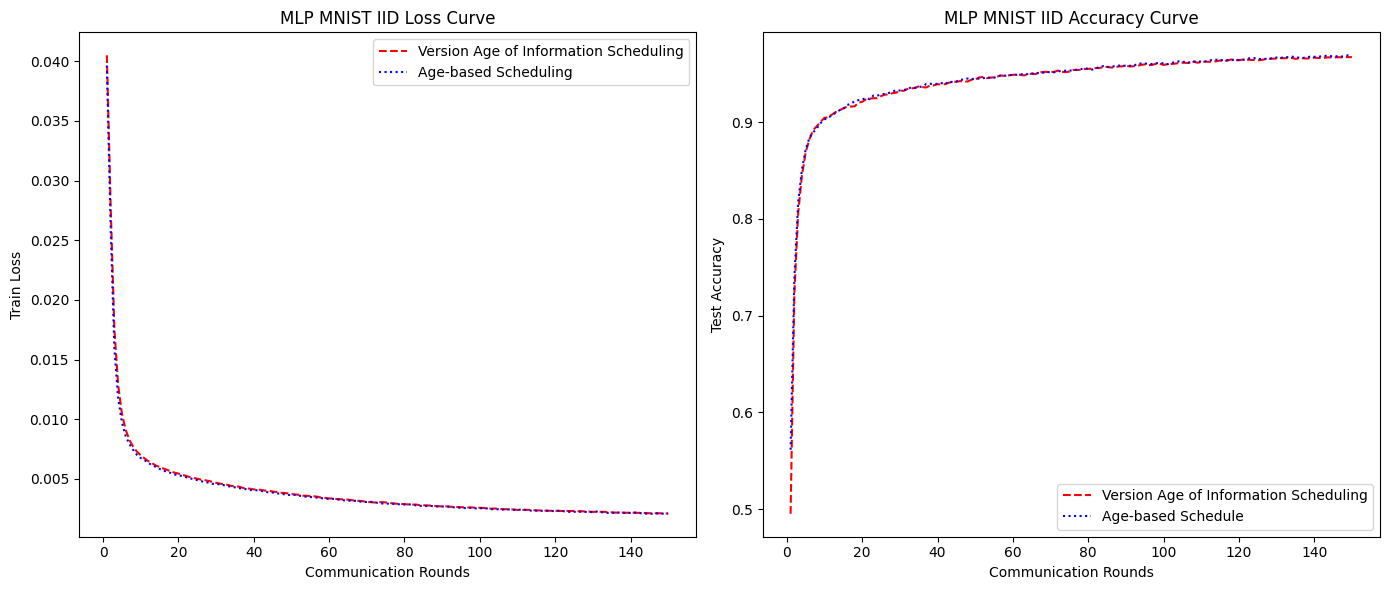

In [285]:
print(f'=================================== Final MLP Model Accuracies per Schedule ====================================')
print(f'Version Age of Information Scheduled MNIST IID Model Accuracy: {iid_MNIST_VAoI_accuracies[-1]},\nAge-based Scheduled MNIST IID Model Accuracy: {iid_MNIST_ABS_accuracies[-1]}')
print(f'================================================================================================================')

epochs_range = range(1, total_rounds + 1)

# Plot Global Training Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, iid_MNIST_VAoI_eval_losses, color='red', linestyle="dashed", label="Version Age of Information Scheduling")
plt.plot(epochs_range, iid_MNIST_ABS_eval_losses, color='blue', linestyle="dotted", label="Age-based Scheduling")
plt.xlabel('Communication Rounds')
plt.ylabel('Train Loss')
plt.legend(loc='upper right')  
plt.title('MLP MNIST IID Loss Curve')

# Plot Global Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, iid_MNIST_VAoI_accuracies, color='red', linestyle="dashed", label="Version Age of Information Scheduling")
plt.plot(epochs_range, iid_MNIST_ABS_accuracies, color='blue', linestyle="dotted", label="Age-based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right') 
plt.title('MLP MNIST IID Accuracy Curve')

plt.tight_layout()
plt.savefig('.\\Plots\\mnist_iid_VAoI_results.png')
plt.show()

<h3>CNN Model Training with CIFAR-10 IID</h3>

Training is done using *'Random'* Scheduling, *'Age-based'* Scheduling, and *'Age of Update OR Data Shapley'* Scheduling (See RNG_training, ABS_training, AoU_OR_DataShapley)

In [286]:
CIFAR10_iid_VAoI = CNN().to(device)
CIFAR10_iid_ABS = CNN().to(device)

print("\n=== Training: Model - CNN, Schedule - Version Age of Information, Data Distribution - CIFAR10 IID ===")
iid_CIFAR10_VAoI_avg_losses, iid_CIFAR10_VAoI_eval_losses, iid_CIFAR10_VAoI_accuracies = VAoI_training(CNN, CIFAR10_iid_VAoI, lr, total_clients, clients_per_round, total_rounds, local_epochs, CIFAR10_training, CIFAR10_validation, tau)

print("\n=== Training: Model - CNN, Schedule - Age-Based, Data Distribution - IID CIFAR-10 ===")
iid_CIFAR10_ABS_avg_losses, iid_CIFAR10_ABS_eval_losses, iid_CIFAR10_ABS_accuracies = ABS_training(CNN, CIFAR10_iid_ABS, lr, total_clients, clients_per_round, total_rounds, local_epochs, CIFAR10_training, CIFAR10_validation)

# Save Final Model
torch.save(CIFAR10_iid_VAoI.state_dict(), '.\\Models\\CIFAR10_iid_VAoI.pth')


=== Training: Model - CNN, Schedule - Version Age of Information, Data Distribution - CIFAR10 IID ===
Round   1, Time (secs) 8.19: Average loss 2.3022, Validation Loss 0.0460, Validation Accuracy 0.1092
Round  11, Time (secs) 78.02: Average loss 2.2977, Validation Loss 0.0460, Validation Accuracy 0.1264
Round  21, Time (secs) 146.76: Average loss 2.2522, Validation Loss 0.0452, Validation Accuracy 0.1902
Round  31, Time (secs) 216.47: Average loss 2.1788, Validation Loss 0.0436, Validation Accuracy 0.2799
Round  41, Time (secs) 286.01: Average loss 2.1329, Validation Loss 0.0428, Validation Accuracy 0.3135
Round  51, Time (secs) 355.77: Average loss 2.1107, Validation Loss 0.0424, Validation Accuracy 0.3397
Round  61, Time (secs) 425.31: Average loss 2.0867, Validation Loss 0.0419, Validation Accuracy 0.3627
Round  71, Time (secs) 495.85: Average loss 2.1128, Validation Loss 0.0416, Validation Accuracy 0.3787
Round  81, Time (secs) 567.24: Average loss 2.0481, Validation Loss 0.0414, 

<h4>CNN Model Training/Inferencing Experience Comparison for CIFAR-10 IID</h4>

=================================== Final CNN Model Accuracies per Schedule ====================================
Version Age of Information Scheduled MNIST IID Model Accuracy: 2.1309443950653075,
Age-based Scheduled MNIST IID Model Accuracy: 2.1103740692138673


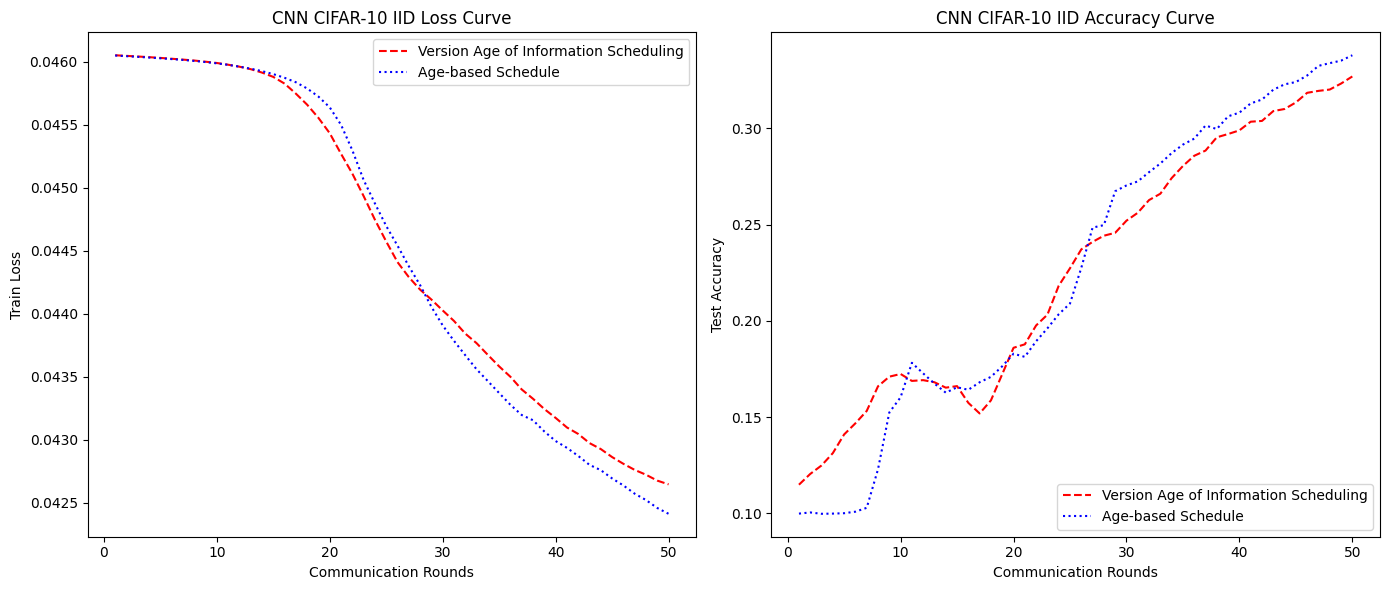

In [ ]:
print(f'=================================== Final CNN Model Accuracies per Schedule ====================================')
print(f'Version Age of Information Scheduled MNIST IID Model Accuracy: {iid_CIFAR10_VAoI_accuracies[-1]},\nAge-based Scheduled MNIST IID Model Accuracy: {iid_CIFAR10_ABS_accuracies[-1]}')
print(f'================================================================================================================')

epochs_range = range(1, total_rounds + 1)

# Plot Global Training Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, iid_CIFAR10_VAoI_eval_losses, color='red', linestyle="dashed", label="Version Age of Information Scheduling")
plt.plot(epochs_range, iid_CIFAR10_ABS_eval_losses, color='blue', linestyle="dotted", label="Age-based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Train Loss')
plt.legend(loc='upper right')  
plt.title('CNN CIFAR-10 IID Loss Curve')

# Plot Global Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, iid_CIFAR10_VAoI_accuracies, color='red', linestyle="dashed", label="Version Age of Information Scheduling")
plt.plot(epochs_range, iid_CIFAR10_ABS_accuracies, color='blue', linestyle="dotted", label="Age-based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right') 
plt.title('CNN CIFAR-10 IID Accuracy Curve')

plt.tight_layout()
plt.savefig('.\\Plots\\cifar10_iid_VAoI_results.png')
plt.show()

<h2>Non-IID Data Preparation for MNIST Dataset</h2>

<t>*The Non-IID data is sorted by digit label, divided up into 200 'shards' of 300 examples, and then each client receieves 2 'shards'*</t>

In [ ]:
# MNIST Non-IID Dataset
training_labels = torch.stack([MNIST_training_dataset.targets == i for i in range(10)])
training_labels_split = []

for i in range(5):
    training_labels_split += torch.split(torch.where(training_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(len(MNIST_training_dataset.data) / total_clients))
training_dataset_split = [torch.utils.data.Subset(MNIST_training_dataset, labels) for labels in training_labels_split]
MNIST_noniid_training = [torch.utils.data.DataLoader(x, batch_size=local_batchsize, shuffle=True) for x in training_dataset_split]

MNIST_noniid_validation = torch.utils.data.DataLoader(MNIST_validation_dataset, batch_size=local_batchsize, shuffle=True)

<h3>MLP Model Training with MNIST Non-IID</h3>

Training is done using *'Random'* Scheduling, *'Age-based'* Scheduling, and *'Age of Update OR Data Shapley'* Scheduling (See RNG_training, ABS_training, AoU_OR_DataShapley)

In [ ]:
MNIST_noniid_VAoI = MLP().to(device)
MNIST_noniid_ABS = MLP().to(device)

print("\n=== Training: Model - MLP, Schedule - Version Age of Information, Data Distribution - MNIST Non-IID ===")
noniid_MNIST_VAoI_avg_losses, noniid_MNIST_VAoI_eval_losses, noniid_MNIST_VAoI_accuracies = VAoI_training(MLP, MNIST_noniid_VAoI, lr, total_clients, clients_per_round, total_rounds, local_epochs, MNIST_noniid_training, MNIST_noniid_validation, tau)

print("\n=== Training: Model - MLP, Schedule - Age-Based, Data Distribution - MNIST Non-IID  ===")
noniid_MNIST_ABS_avg_losses, noniid_MNIST_ABS_eval_losses, noniid_MNIST_ABS_accuracies = ABS_training(MLP, MNIST_noniid_ABS, lr, total_clients, clients_per_round, total_rounds, local_epochs, MNIST_noniid_training, MNIST_noniid_validation)

# Save Final Model
torch.save(MNIST_iid_VAoI.state_dict(), '.\\Models\\MNIST_noniid_VAoI.pth')


=== Training: Model - MLP, Schedule - Version Age of Information, Data Distribution - MNIST Non-IID ===
Round   1, Time (secs) 6.89: Average loss 0.1570, Validation Loss 0.0435, Validation Accuracy 0.2645
Round  11, Time (secs) 75.47: Average loss 0.0327, Validation Loss 0.0217, Validation Accuracy 0.6370
Round  21, Time (secs) 147.33: Average loss 0.0338, Validation Loss 0.0201, Validation Accuracy 0.6610
Round  31, Time (secs) 218.95: Average loss 0.0314, Validation Loss 0.0195, Validation Accuracy 0.6447
Round  41, Time (secs) 291.61: Average loss 0.0286, Validation Loss 0.0183, Validation Accuracy 0.6439

=== Training: Model - MLP, Schedule - Age-Based, Data Distribution - MNIST Non-IID  ===
Round   1, Time (secs) 7.25: Average loss 0.2102, Validation Loss 0.0804, Validation Accuracy 0.1957
Round  11, Time (secs) 77.92: Average loss 0.0854, Validation Loss 0.0686, Validation Accuracy 0.2171
Round  21, Time (secs) 150.45: Average loss 0.0584, Validation Loss 0.0638, Validation Accu

<h4>MLP Model Training/Inferencing Experience Comparison for MNIST Non-IID</h4>

=================================== Final MLP Model Accuracies per Schedule ====================================
Version Age of Information Scheduled MNIST IID Model Accuracy: 0.03790002478053793,
Age-based Scheduled MNIST IID Model Accuracy: 0.021821693051606417


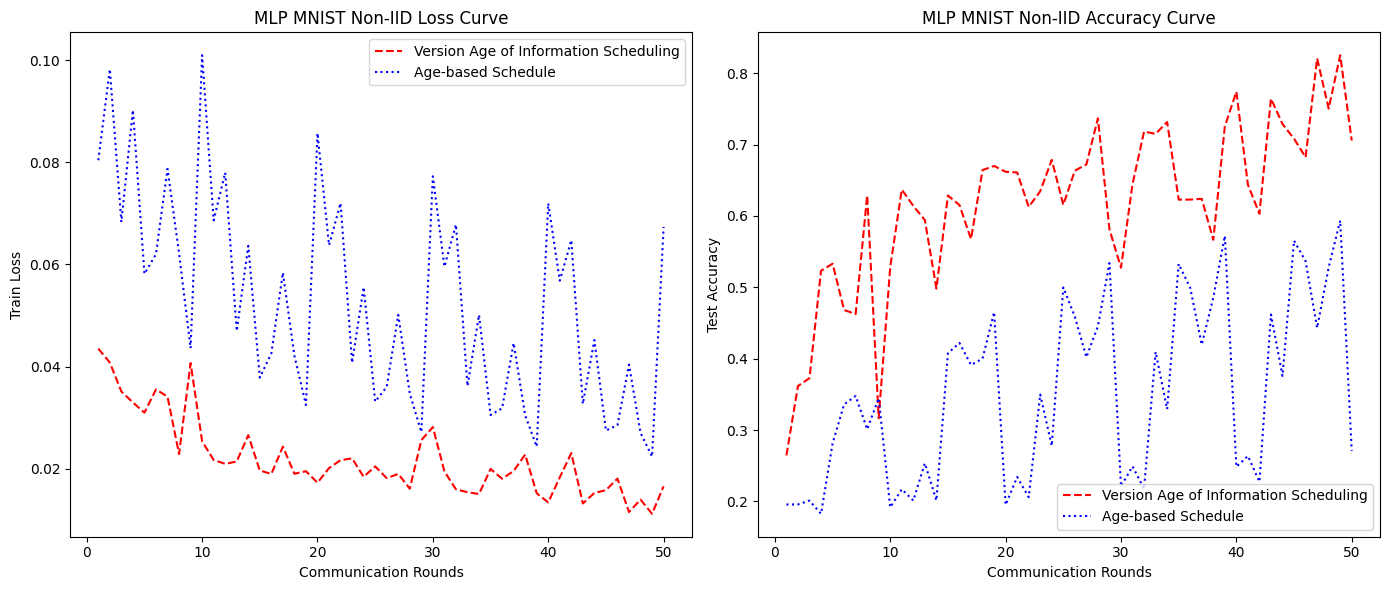

In [ ]:
print(f'=================================== Final MLP Model Accuracies per Schedule ====================================')
print(f'Version Age of Information Scheduled MNIST IID Model Accuracy: {noniid_MNIST_VAoI_accuracies[-1]},\nAge-based Scheduled MNIST IID Model Accuracy: {noniid_MNIST_ABS_accuracies[-1]}')
print(f'================================================================================================================')

epochs_range = range(1, total_rounds + 1)

# Plot Global Training Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, noniid_MNIST_VAoI_eval_losses, color='red', linestyle="dashed", label="Version Age of Information Scheduling")
plt.plot(epochs_range, noniid_MNIST_ABS_eval_losses, color='blue', linestyle="dotted", label="Age-based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Train Loss')
plt.legend(loc='upper right')  
plt.title('MLP MNIST Non-IID Loss Curve')

# Plot Global Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, noniid_MNIST_VAoI_accuracies, color='red', linestyle="dashed", label="Version Age of Information Scheduling")
plt.plot(epochs_range, noniid_MNIST_ABS_accuracies, color='blue', linestyle="dotted", label="Age-based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right') 
plt.title('MLP MNIST Non-IID Accuracy Curve')

plt.tight_layout()
plt.savefig('.\\Plots\\mnist_noniid_VAoI_results.png')
plt.show()

<h2>Global Model Complexity Comparisons</h2>

In [ ]:
def print_model_summary(model, model_name, dataset_name):
    if dataset_name == "MNIST":
        input_size = (1, 28, 28)
    elif dataset_name == "CIFAR-10":
        input_size = (3, 32, 32)

    model_stats = summary(model, input_size=input_size, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
    print(f"\n{'='*30} {model_name} {'='*30}")
    print(model_stats)
    print('='*80)

print("\t\t\t\tMLP Model Comparisons using MNIST IID\n")
print_model_summary(MNIST_iid_VAoI, "Version Age of Information IID Model", "MNIST")
print_model_summary(MNIST_iid_ABS, "Age-Based IID Model", "MNIST")
print()

print("\t\t\t\tMLP Model Comparisons using MNIST Non-IID\n")
print_model_summary(MNIST_noniid_VAoI, "Version Age of Information Non-IID Model", "MNIST")
print_model_summary(MNIST_noniid_ABS, "Age-Based Non-IID Model", "MNIST")
print()

print("\t\t\t\tCNN Model Comparisons using CIFAR10 IID\n")
print_model_summary(CIFAR10_iid_VAoI, "Version Age of Information IID Model", "CIFAR-10")
print_model_summary(CIFAR10_iid_ABS, "Age-Based IID Model", "CIFAR-10")



				MLP Model Comparisons using MNIST IID


============================== Version Age of Information IID Model ==============================
Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
MLP (MLP)                                --               [1, 10]          --               --
├─Linear (fc1)                           --               [1, 128]         100,480          100,480
├─Linear (fc2)                           --               [1, 64]          8,256            8,256
├─Linear (fc3)                           --               [1, 10]          650              650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.44
Estimated Total Size (MB): 0.44

============================== Age-Based IID Model ==============================
Layer (type (var_name))                  Kernel Shape   

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1, Conv2d: 1]